In [1]:
from pymongo import MongoClient
from dotenv import load_dotenv
import pandas as pd
import json
import os
import re

In [6]:
load_dotenv()

mongo_user = os.getenv('MONGO_INITDB_ROOT_USERNAME')
mongo_password = os.getenv('MONGO_INITDB_ROOT_PASSWORD')
mongo_host = 'localhost'
mongo_port = '27017'
mongo_db = 'raw_data'
connection_string = f'mongodb://{mongo_user}:{mongo_password}@{mongo_host}:{mongo_port}/'


In [7]:
collection_name = 'reed_test'

In [8]:
client = MongoClient(connection_string)
db = client[mongo_db]
collection = db[collection_name]

In [9]:
print(client.list_database_names())

['admin', 'config', 'local', 'raw_data']


In [10]:
display(db['reed_test'].find_one())

{'_id': ObjectId('660af8c610971b803a326a21'),
 'employerId': '596284',
 'employerName': 'Hertfordshire County Council',
 'employerProfileId': 'None',
 'employerProfileName': 'None',
 'jobTitle': 'Assistant Customer Service Supervisor',
 'locationName': 'Abbots Langley',
 'minimumSalary': '23500.0',
 'maximumSalary': '25979.0',
 'currency': 'GBP',
 'expirationDate': '13/04/2024',
 'date': '14/03/2024',
 'jobDescription': 'Job Title: Assistant Customer Service Supervisor Location: Abbots Langley Starting Salary: 23,500 with the opportunity to progress to 25,979 per annum (pro rata for part-time) Hours: 18 hours per week Contract: Permanent Diversity: We are an inclusive employer and value a diverse workforce Do you want to make a difference in the community and help people to enrich their lives, whilst progressing in a whole new career? Then apply for a job with H...',
 'applications': '34',
 'jobUrl': 'https://www.reed.co.uk/jobs/assistant-customer-service-supervisor/52311653',
 'source

In [11]:
print("The number of jobs with salary information is", 
    collection.count_documents({
    "$and": [
        {"minimumSalary": {"$ne": 'None'}},
        {"maximumSalary": {"$ne": 'None'}}
    ]
})
)

The number of jobs with salary information is 656466


In [12]:
pipeline = [
    {
        "$match": {
            "$and": [
                {"minimumSalary": {"$eq": 'None'}},
                {"maximumSalary": {"$eq": 'None'}}
            ]
        }
    },
    {
        "$group": {
            "_id": None,  # Grouping all matching documents together
            "count": {"$sum": 1}  # Counting the documents
        }
    }
]

result = list(collection.aggregate(pipeline))

if result:
    print("The number of jobs without salary information is", result[0]['count'])
else:
    print("No jobs found without salary information.")


The number of jobs without salary information is 86762


In [13]:

# Query to select documents where none of the specified fields are empty
query = {
    "$and": [
        {"jobTitle": {"$regex": "data", "$options": "i"}},  # Case-insensitive search for "data" in jobTitle
        {"locationName": {"$ne": ""}},
        {"minimumSalary": {"$ne": ""}},
        {"maximumSalary": {"$ne": ""}},
        {"currency": {"$ne": ""}}
    ]
}

# Projection to specify fields to include, adding 'jobDescription' to the projection
projection = {
    "jobTitle": 1,
    "locationName": 1,
    "minimumSalary": 1,
    "maximumSalary": 1,
    "currency": 1,
    "jobDescription": 1,
    "_id": 0
}

# Fetching the documents with projection
documents = collection.find(query, projection)

def determine_salary_period(description, min_salary, max_salary):
    # Extract the integer part of the min_salary
    min_salary_int = re.match(r'^\d+', str(min_salary))
    if min_salary_int:
        min_salary_int = min_salary_int.group(0)
    else:
        # If no numeric part is found, the function returns "Not specified"
        return "Not specified"
    
    # Define possible salary periods with regex patterns to search for them
    # after the min_salary value
    salary_period_patterns = {
        "per hour": f"{min_salary_int}.*per hour",
        "per day": f"{min_salary_int}.*per day",
        "per week": f"{min_salary_int}.*per week",
        "per month": f"{min_salary_int}.*per month",
        "ph": f"{min_salary_int}.*ph",
        "pd": f"{min_salary_int}.*pd"
    }
    
    # Search for each period pattern in the description
    for period, pattern in salary_period_patterns.items():
        if re.search(pattern, description, re.IGNORECASE):
            return period
    
    # If no period pattern is found, attempt to deduce the period
    # if len(str(min_salary)) >= 6 or len(str(max_salary)) >= 6:
    #     return "per year"
    
    return "Not specified"

data_objects = []
for doc in documents:
    # Determine the salary period
    salary_period = determine_salary_period(doc['jobDescription'], doc['minimumSalary'], doc['maximumSalary'])
    # Add the new field to the document
    doc['salaryPeriod'] = salary_period
    data_objects.append(doc)


In [14]:
# Creating the DataFrame
df_reed = pd.DataFrame(data_objects)

# Showing the first few rows of the DataFrame to verify
display(df_reed.head())

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod
0,Data and Examinations Officer,Kings Langley,22596.0,24589.0,GBP,Job Title: Term Time Data and Examinations Off...,Not specified
1,"Data, Examinations and Admissions Officer",WD49HN,22596.0,24589.0,GBP,"Position: Data, Examinations and Admissions Of...",Not specified
2,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
3,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
4,Online Data & Insights Manager,HP79FB,50000.0,55000.0,GBP,"Online Data and Insights Manager - 50,000- 55,...",Not specified


In [15]:
# Creating the dataframe
#df_reed = pd.DataFrame(data_objects)
print(df_reed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobTitle        8777 non-null   object
 1   locationName    8777 non-null   object
 2   minimumSalary   8777 non-null   object
 3   maximumSalary   8777 non-null   object
 4   currency        8777 non-null   object
 5   jobDescription  8777 non-null   object
 6   salaryPeriod    8777 non-null   object
dtypes: object(7)
memory usage: 480.1+ KB
None


In [16]:
df_reed['minimumSalary'] = pd.to_numeric(df_reed['minimumSalary'], errors='coerce')
df_reed['maximumSalary'] = pd.to_numeric(df_reed['maximumSalary'], errors='coerce')

df_reed.head(10)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod
0,Data and Examinations Officer,Kings Langley,22596.0,24589.0,GBP,Job Title: Term Time Data and Examinations Off...,Not specified
1,"Data, Examinations and Admissions Officer",WD49HN,22596.0,24589.0,GBP,"Position: Data, Examinations and Admissions Of...",Not specified
2,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
3,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
4,Online Data & Insights Manager,HP79FB,50000.0,55000.0,GBP,"Online Data and Insights Manager - 50,000- 55,...",Not specified
5,Data Migration Temp,Borehamwood,14.0,15.0,GBP,Temporary Data focused temp required for a bus...,Not specified
6,CRM & Customer Data Manager,HP11AE,50000.0,55000.0,GBP,Proximity Recruitment are searching for a dyna...,Not specified
7,Data Entry Clerk,Watford,NaN,NaN,None,Job Opportunity: Data Entry Clerk (Temporary) ...,Not specified
8,Online Data and Insight Manager,Amersham,40000.0,50000.0,GBP,Online Data and Insight Manager Amersham Perma...,Not specified
9,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified


In [17]:
df_reed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jobTitle        8777 non-null   object 
 1   locationName    8777 non-null   object 
 2   minimumSalary   7787 non-null   float64
 3   maximumSalary   7787 non-null   float64
 4   currency        8777 non-null   object 
 5   jobDescription  8777 non-null   object 
 6   salaryPeriod    8777 non-null   object 
dtypes: float64(2), object(5)
memory usage: 480.1+ KB


In [18]:
df_reed.dropna(inplace=True)

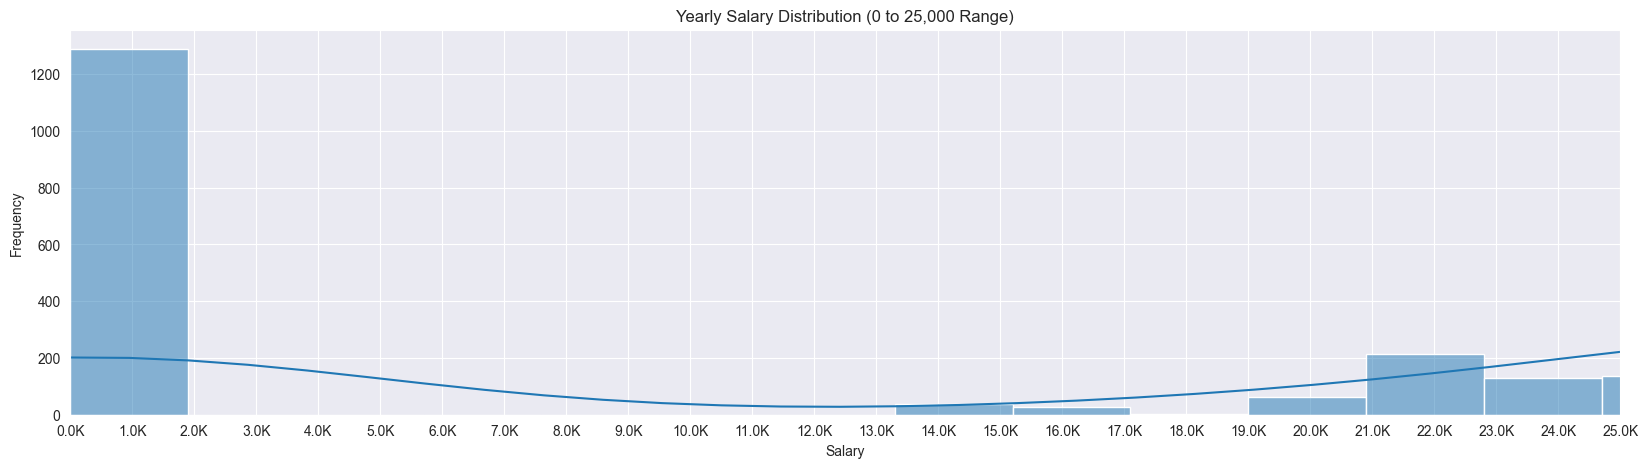

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20, 5))
# Adjust the bin size and limit the x-axis to focus on 0 to 25,000 range
sns.histplot(df_reed['minimumSalary'], bins=100, kde=True)
plt.xlim(0, 25000)  # Focus on the 0 to 25,000 range

# Customize x-axis tick labels for better clarity
plt.xticks(range(0, 25001, 1000), labels=[f'{x/1000}K' for x in range(0, 25001, 1000)])

plt.title('Yearly Salary Distribution (0 to 25,000 Range)')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

In [19]:
df_reed.sort_values(by='minimumSalary', inplace=True)
test_list = df_reed['minimumSalary']

unique_list = list(dict.fromkeys(test_list))
print(unique_list)


[0.0, 10.0, 10.39, 10.42, 10.5, 10.92, 10.93, 10.95, 11.17, 11.3, 11.44, 11.5, 12.0, 12.11, 12.25, 12.5, 12.55, 12.72, 12.82, 12.87, 12.92, 13.0, 13.03, 14.0, 14.46, 14.66, 15.0, 15.38, 15.52, 17.0, 17.86, 18.01, 20.0, 21.0, 22.01, 22.51, 24.0, 35.09, 39.71, 41.35, 52.0, 60.0, 65.0, 92.52, 100.0, 110.0, 160.0, 170.0, 200.0, 250.0, 300.0, 325.0, 350.0, 400.0, 450.0, 480.0, 495.0, 500.0, 550.0, 600.0, 650.0, 700.0, 900.0, 13500.0, 14000.0, 14144.0, 15000.0, 16000.0, 18000.0, 20000.0, 21000.0, 21450.0, 22000.0, 22500.0, 22596.0, 22681.0, 23000.0, 23350.0, 23400.0, 23868.0, 24000.0, 24294.0, 24500.0, 24800.0, 25000.0, 25681.0, 26000.0, 27000.0, 27500.0, 27789.0, 28000.0, 28500.0, 29000.0, 29777.0, 30000.0, 30151.0, 30225.0, 30473.0, 30984.0, 32000.0, 32287.0, 32500.0, 33000.0, 33024.0, 33500.0, 33850.0, 33945.0, 34000.0, 34326.0, 34393.0, 35000.0, 35392.0, 36090.0, 37000.0, 37099.0, 37242.0, 38000.0, 38746.0, 39267.0, 40000.0, 40038.0, 40439.0, 40701.0, 41000.0, 41206.0, 41383.0, 41659.0, 

In [20]:
df_reed = df_reed[df_reed['minimumSalary'] > 0]

In [21]:
df_reed['salaryPeriod'].value_counts()

salaryPeriod
Not specified    7440
per day           156
per hour          101
ph                 41
pd                 26
per week            6
Name: count, dtype: int64

In [22]:
def transform_salary_to_yearly(df, salary_col, period_col):
    """
    Adjusts salary values in the DataFrame to yearly equivalents based on the salary period.
    
    Parameters:
    - df: Pandas DataFrame containing the salary data.
    - salary_col: The name of the column containing the salary values.
    - period_col: The name of the column containing the salary period descriptions.
    """
    
    # Ensure the columns exist in the DataFrame
    if salary_col not in df.columns:
        raise ValueError(f"Column '{salary_col}' not found in DataFrame")
    if period_col not in df.columns:
        raise ValueError(f"Column '{period_col}' not found in DataFrame")
    
    # Conversion rates based on the salary period
    conversion_rates = {
        "per year": 1,
        "per month": 12,
        "per week": 52,
        "per day": 260,  # Assuming 5 working days per week
        "pd" : 260,
        "per hour": 2080,  # Assuming 40 hours per week
        "ph": 2080,
        "Not specified": 1  # No change for unspecified
    }
    
    # Define a function to convert salary to yearly
    def salary_to_yearly(row):
        period = row[period_col]
        salary = row[salary_col]
        # Handle non-numeric salaries by returning them unmodified
        try:
            numeric_salary = float(salary)
        except ValueError:
            return salary  # Return the original salary if it's not a numeric value
        
        # Apply conversion based on the salary period
        if period in conversion_rates:
            return numeric_salary * conversion_rates[period]
        else:
            return numeric_salary  # Return the original salary if the period is unexpected

    # Apply the conversion function to rows
    df[salary_col + '_yearly'] = df.apply(salary_to_yearly, axis=1)
    
    return df


In [23]:
for column in ['minimumSalary', 'maximumSalary']:
    df_reed_salary_tr = transform_salary_to_yearly(df_reed, column, 'salaryPeriod')
    
df_reed_salary_tr.head(2000)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,Not specified,10.0,10.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,Not specified,10.0,10.0
...,...,...,...,...,...,...,...,...,...
4965,Data Centre Technician,Farnborough,28000.0,32000.0,GBP,Data Centre Technician 28000 - 32000 Farnborou...,Not specified,28000.0,32000.0
6830,Systems & Data Analyst,M202AF,28000.0,28000.0,GBP,Innova Search are partnering with a leading br...,Not specified,28000.0,28000.0
6218,"Data Analyst, Python, Pandas, Fully Remote, CO...",M607RA,28000.0,34000.0,GBP,"Data Analyst, Python, Pandas, Fully Remote, CO...",Not specified,28000.0,34000.0
6837,"Data Analyst, Python, Pandas, Fully Remote, CO...",M607RA,28000.0,34000.0,GBP,"Data Analyst, Python, Pandas, Fully Remote, CO...",Not specified,28000.0,34000.0


In [24]:
df_reed_salary_tr.loc[df_reed_salary_tr['minimumSalary'] < 70, 'salaryPeriod'] = 'per hour'
df_reed_salary_tr.loc[(df_reed_salary_tr['minimumSalary'] >= 70) & (df_reed_salary_tr['minimumSalary'] < 999), 'salaryPeriod'] = 'per day'
df_reed_salary_tr.head(200)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,10.0,10.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,10.0,10.0
...,...,...,...,...,...,...,...,...,...
2498,Data Processor,Clapham,14.0,14.0,GBP,Data Processor Clapham 14 per hour Full-Time T...,per hour,29120.0,29120.0
1604,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
4011,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
3172,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0


In [25]:
for column in ['minimumSalary', 'maximumSalary']:
    df_reed_salary_tr = transform_salary_to_yearly(df_reed, column, 'salaryPeriod')
df_reed_salary_tr.head(200)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
...,...,...,...,...,...,...,...,...,...
2498,Data Processor,Clapham,14.0,14.0,GBP,Data Processor Clapham 14 per hour Full-Time T...,per hour,29120.0,29120.0
1604,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
4011,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
3172,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0


In [26]:
display(df_reed_salary_tr.loc[df_reed_salary_tr['salaryPeriod'] == 'Not specified'])

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8523,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
4735,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
8578,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
8541,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
958,Head of Group Data Management,London,14000.0,14000.0,GBP,Eames is currently partnered with a global (re...,Not specified,14000.0,14000.0
...,...,...,...,...,...,...,...,...,...
7862,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
7993,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
6415,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
1242,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0


In [27]:
import spacy

# Load the pre-trained model
nlp = spacy.load('en_core_web_sm')  # Or 'en_core_web_lg' for more accuracy but larger size      


# Categorize job titles
def categorize_seniority(job_title):
    doc = nlp(job_title)
    # List of keywords (lemmas) to look for
    keywords_senior = ['strategic', 'principal', 'staff', 'lead', 'senior', 'head']
    keywords_junior = ['trainee', 'junior', 'apprentice', 'entry level' ]
    # Check if any token's lemma is in our keywords list
    if any(token.lemma_.lower() in keywords_senior for token in doc):
        return 'Senior'
    elif any(token.lemma_.lower() in keywords_junior for token in doc):
        return 'Junior'
    else:
        return 'Any'

# Apply the function to create a new column
df_reed_salary_tr['jobLevel'] = df_reed_salary_tr['jobTitle'].apply(categorize_seniority)

In [28]:
print(df_reed_salary_tr['jobLevel'].value_counts())
df_reed.head()

jobLevel
Any       5063
Senior    1750
Junior     957
Name: count, dtype: int64


,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly,jobLevel
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0,Any
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0,Any
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0,Any
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0,Any
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0,Any


In [29]:
df_reed_salary_tr['jobTitle'].unique()

array(['Data Entry', 'Data Entry Administrator  - Remote',
       'Data Entry Administrator', 'Data Administrator',
       'Administrator/Data Entry', 'Data Entry Clerk',
       'Data Entry Clerk / Coordinator',
       'Part Time Data Entry Administrator- City Centre',
       'Data Entry Administrator - 3 days per week',
       'Temporary Data Entry Administrator',
       'Telephone Data Cleansing Admin', 'Medical Data Entry',
       'Admin Officer/Data Entry', 'Data Entry Administrators',
       'Data Migration Assistant', 'Temporary Data Administrator',
       'Exams and Data Officer - Part Time', 'Data Cleanser',
       'Data Entry temp to permanent', 'Data Entry Assistant',
       'Data Entry Operatives - Summer Work starts May 2024!',
       'Administrator / Data Entry',
       'Data Administrator Oracle/SalesForce',
       'Data Entry 2 months temporary, Bath',
       'Criminal Justice PNC Data Officer', 'Data Inputter IRB Operator',
       'Temporary Data Administrator - £14 per

In [30]:
# Define your lists of skills, technologies, and site preferences
keywords_skills = [
    "SQL", "Structured Query Language", "Python", "R", "Docker", "AWS", "Amazon Web Services",
    "Azure", "Google Cloud Platform", "GCP", "Snowflake", "Hadoop", "Spark", "Kubernetes",
    "Jenkins", "BI", "Business Intelligence", "Tableau", "Power BI", "Looker", "ETL",
    "Extract Transform Load", "Informatica", "Talend", "SSIS", "CRM",
    "Customer Relationship Management", "Salesforce", "SAP", "Git", "NoSQL", "MongoDB",
    "Cassandra", "PostgreSQL", "MySQL", "Data Modeling", "Machine Learning", "ML", "AI",
    "Apache Kafka", "Redis", "Elasticsearch", "Kibana", "Ansible", "REST", "RESTful", "API",
    "GraphQL", "Linux", "Matplotlib", "Seaborn", "Jupyter Notebook", "Scikit-learn",
    "TensorFlow", "PyTorch", "Data Lakes", "Data Warehousing", "Agile", "Scrum", "Blockchain",
    "Edge Computing", "VMware", "SAS", "Flask", "Django", "Apache", "Airflow", "Luigi", "NLP",
    "Databricks", "redshift", "Excel", "HANA", "Oracle", "crypto"
]

keywords_site = ['remote', 'hybrid', 'on-site']

# Function to categorize job titles and descriptions by keywords, accepting a keyword list as a parameter
def categorize_by_keywords(text, keywords):
    doc = nlp(text)
    # Initialize an empty set to avoid duplicates
    keywords_found = set()
    # Check each token in the text
    for token in doc:
        # Normalize the token's text for case-insensitive matching
        token_text = token.text.lower()
        # If the normalized token is in our list of keywords, add the original token text to the set
        if token_text in [keyword.lower() for keyword in keywords]:
            keywords_found.add(token.text)
    # Return a comma-separated string of unique keywords found, or "None" if no keywords were identified
    return ', '.join(keywords_found) if keywords_found else "None"

# Applying the function to each row for both jobSkills and jobSite columns
df_reed_salary_tr['jobSkills'] = df_reed_salary_tr.apply(lambda row: categorize_by_keywords(row['jobTitle'] + " " + row['jobDescription'], keywords_skills), axis=1)
df_reed_salary_tr['jobSite'] = df_reed_salary_tr.apply(lambda row: categorize_by_keywords(row['jobTitle'] + " " + row['jobDescription'], keywords_site), axis=1)


In [31]:
df_reed_salary_tr['jobSkills'].value_counts()


jobSkills
None                           5423
Azure                           268
AI                              154
SQL                             133
CRM                             115
                               ... 
MongoDB                           1
ETL, BI                           1
BI, Python, Tableau, R            1
AWS, Azure, NLP, Python, AI       1
SQL, Oracle                       1
Name: count, Length: 106, dtype: int64

In [32]:
def remove_matching_terms(row):
    # Split skills and site strings into lists of words; ensure case-insensitive matching by lowering the case
    skills = str(row['jobSkills']).lower().split(', ')
    site = str(row['jobSite']).lower().split(', ')
    
    # Combine skills and site lists for comprehensive matching
    keywords_to_remove = skills + site
    
    # Prepare the job title for processing
    job_title = row['jobTitle'].lower()
    
    # Remove any matching terms from the job title
    for keyword in keywords_to_remove:
        job_title = job_title.replace(keyword, '')
    
    # Return the stripped job title, optionally capitalizing it for consistency
    return ' '.join(job_title.split()).capitalize()

# Apply the function to each row and save the result in a new column 'strippedTitle'
df_reed_salary_tr['strippedTitle'] = df_reed_salary_tr.apply(remove_matching_terms, axis=1)

# Display the DataFrame to verify the changes
df_reed_salary_tr[['jobTitle', 'jobSkills', 'jobSite', 'strippedTitle']].head(100)

,jobTitle,jobSkills,jobSite,strippedTitle
8066,Data Entry,None,None,Data entry
8027,Data Entry Administrator - Remote,None,Remote,Data entry administrator -
8051,Data Entry Administrator - Remote,None,Remote,Data entry administrator -
2885,Data Entry Administrator - Remote,None,Remote,Data entry administrator -
8057,Data Entry,None,None,Data entry
...,...,...,...,...
2495,Data Entry Administrator,None,None,Data entry administrator
2494,Data Entry Administrator,None,None,Data entry administrator
8706,Data Administrator,None,hybrid,Data administrator
1676,Data Migration Assistant,None,None,Data migration assistant


In [29]:
from collections import Counter

# Standardize job titles: lowercase and replace non-alphanumeric characters with spaces
df_reed_salary_tr['standardized_title'] = df_reed_salary_tr['jobTitle'].str.lower().str.replace('[^a-z0-9 ]', ' ', regex=True)

# Tokenize: split the titles into lists of words
df_reed_salary_tr['tokens'] = df_reed_salary_tr['standardized_title'].str.split()

# Flatten the list of tokens and count occurrences
all_tokens = [token for sublist in df_reed_salary_tr['tokens'].tolist() for token in sublist]
token_counts = Counter(all_tokens)

# Display the most common tokens
print(token_counts.most_common())


[('data', 7619), ('analyst', 2536), ('engineer', 1396), ('senior', 986), ('trainee', 849), ('lead', 588), ('manager', 586), ('scientist', 500), ('administrator', 442), ('and', 437), ('architect', 434), ('000', 422), ('protection', 363), ('remote', 322), ('consultant', 292), ('entry', 276), ('bonus', 259), ('governance', 229), ('database', 220), ('analytics', 210), ('london', 209), ('engineering', 197), ('business', 191), ('to', 185), ('management', 181), ('associate', 180), ('sql', 176), ('hybrid', 173), ('up', 159), ('insight', 151), ('aws', 149), ('science', 142), ('azure', 142), ('marketing', 139), ('head', 136), ('of', 136), ('director', 136), ('officer', 134), ('privacy', 132), ('specialist', 131), ('coordinator', 126), ('python', 117), ('school', 109), ('75', 107), ('partner', 105), ('55k', 102), ('graduate', 99), ('crm', 99), ('developer', 94), ('migration', 93), ('advisor', 93), ('systems', 93), ('behavioural', 92), ('for', 90), ('project', 89), ('market', 86), ('agency', 86), 

In [33]:
df_reed_salary_tr[['jobTitle', 'strippedTitle']]

,jobTitle,strippedTitle
8066,Data Entry,Data entry
8027,Data Entry Administrator - Remote,Data entry administrator -
8051,Data Entry Administrator - Remote,Data entry administrator -
2885,Data Entry Administrator - Remote,Data entry administrator -
8057,Data Entry,Data entry
...,...,...
7862,Head of Data Operations,Head of data operations
7993,Head of Data Operations,Head of data operations
6415,Head of Data Operations,Head of data operations
1242,Head of Data Operations,Head of data operations


In [34]:
df_reed_salary_tr['strippedTitle'].unique()

array(['Data entry', 'Data entry administrator -',
       'Data entry administrator', 'Data administrator',
       'Administrator/data entry', 'Data entry clerk',
       'Data entry clerk / coordinator',
       'Part time data entry administrator- city centre',
       'Data entry administrator - 3 days per week',
       'Temporary data entry administrator',
       'Telephone data cleansing admin', 'Medical data entry',
       'Admin officer/data entry', 'Data entry administrators',
       'Data migration assistant', 'Temporary data administrator',
       'Exams and data officer - part time', 'Data cleanser',
       'Data entry temp to permanent', 'Data entry assistant',
       'Data entry operatives - summer work starts may 2024!',
       'Administrator / data entry', 'Data administrator /',
       'Data entry 2 months temporary, bath',
       'Criminal justice pnc data officer', 'Data inputter irb operator',
       'Temporary data administrator - £14 per hour',
       'Data protection

In [35]:
df_reed_salary_tr[['jobTitle', 'strippedTitle']].to_csv('reed_titles.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'reed_titles.csv'

In [42]:
keywords_title = {
    "data administrator": ["data", "administrator", "entry", "protection", "officer", "clerk", "admin", "migration", "cleanser", "inputter", "coordinator", "assistant", "pocessor", "auditor", "governance", "apprentice", "executive", "manager"],
    "data engineer": ["data", "engineer", "developer", "engineering", "modeller", "technical"],
    "data analyst": ["data", "analyst", "analytics", "analysis", "investigation", "workstream", "visualisation", "insight", "consultant"],
    "database administrator": ["database", "administrator", "assistant", "manager"],
    "data scientist": ["data", "scientist", "science", "engineer"],
    "data center": ["data", "center", "cabling", "installer", "installation", "engineer"],
    "data test": ["data", "test", "tester", "automation", "processing"],
    "data architect": ["data", "architect"],
    "manager": ["head", "manager", "director", "procurement", "management"]  
}

In [43]:
import pandas as pd
import re
from collections import defaultdict


def categorize_job_titles(job_title, keywords_title):
    # Prepare the job title: lowercase, remove special characters, and split into words
    words = re.sub('[^a-z0-9\s]', '', job_title.lower()).split()
    
    # Initialize a dictionary to hold the count of matches for each category
    matches = defaultdict(int)
    # Initialize a dictionary to hold the sum of indexes for matched words for tie-breaking
    index_sums = defaultdict(int)
    
    for category, keywords in keywords_title.items():
        for word in words:
            if word in keywords:
                matches[category] += 1
                # Sum the indexes of matched words for tie-breaking
                index_sums[category] += keywords.index(word)
    
    if not matches:
        return 'Other'
    
    # Find the category(ies) with the maximum count of matches
    max_matches = max(matches.values())
    candidates = [category for category, count in matches.items() if count == max_matches]
    
    # If there's a single best match, return it
    if len(candidates) == 1:
        return candidates[0]
    
    # If there are ties, use the sum of indexes for tie-breaking
    return min(candidates, key=lambda category: index_sums[category])

# Apply the function to the 'jobTitle' column and create a new 'jobCategory' column
df_reed_salary_tr['jobCategory'] = df_reed_salary_tr['jobTitle'].apply(lambda x: categorize_job_titles(x, keywords_title))


In [44]:
df_reed_salary_tr[['jobTitle', 'jobCategory']]


,jobTitle,jobCategory
8066,Data Entry,data administrator
8027,Data Entry Administrator - Remote,data administrator
8051,Data Entry Administrator - Remote,data administrator
2885,Data Entry Administrator - Remote,data administrator
8057,Data Entry,data administrator
...,...,...
7862,Head of Data Operations,data administrator
7993,Head of Data Operations,data administrator
6415,Head of Data Operations,data administrator
1242,Head of Data Operations,data administrator


In [40]:
display(df_reed_salary_tr.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 8066 to 1154
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   jobTitle              7770 non-null   object 
 1   locationName          7770 non-null   object 
 2   minimumSalary         7770 non-null   float64
 3   maximumSalary         7770 non-null   float64
 4   currency              7770 non-null   object 
 5   jobDescription        7770 non-null   object 
 6   salaryPeriod          7770 non-null   object 
 7   minimumSalary_yearly  7770 non-null   float64
 8   maximumSalary_yearly  7770 non-null   float64
 9   jobLevel              7770 non-null   object 
 10  jobSkills             7770 non-null   object 
 11  jobSite               7770 non-null   object 
 12  strippedTitle         7770 non-null   object 
 13  jobCategory           7770 non-null   object 
dtypes: float64(4), object(10)
memory usage: 910.5+ KB


None

In [46]:
df_reed_salary_tr.to_csv('reed_dataset_for_Yue.csv', index=False)

In [45]:
df_reed_salary_tr['jobCategory'].value_counts()

jobCategory
data analyst              2782
data administrator        2017
data engineer             1568
data scientist             617
data architect             432
database administrator     214
manager                     65
data center                 46
data test                   29
Name: count, dtype: int64